### FE621 - Homework #3

**Author**: Sid Bhatia

**Date**: April 5th, 2023

**Pledge**: I pledge my honor that I have abided by the Stevens Honor System.

**Professor**: Sveinn Olafsson

**TA**: Dong Woo Kim

#### Problem #1 (Monte Carlo Error)

Use Monte Carlo simulation to price a European call option in the Black-Scholes model with the following parameters: $S_0 = 100, \sigma = 0.30, r = 0.05, T = 1,$ and $K = 100$.

a. Use (exact) simulation based on the closed-form solution of geometric Brownian motion. Use $n = 100000$ paths. 

Clearly describe the steps of your simulation procedure, and provide formulas for the Monte Carlo estimator and a corresponding 95% confidence interval. Report both the estimator and the confidence interval. Does the confidence interval contain the true price of the option?

##### Procedure

1. **Simulation of Stock Prices**: According to BSM, the stock process $S_t$ at future time $t$ is as follows:

$$S_t = S_0 \exp\{(r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z_T\}$$

where

- $S_0$ = initial stock price
- $r$ = rfr (e.g., 3-month UST)
- $\sigma$ = vol
- $T$ = time till maturity
- $Z_T$ = standard normal $\sim \mathcal{N}(0, 1)$

2. **Payoff Calculation**: For a call option, the payoff at maturity is $(S_T - K)_+$ where $K$ is the strike price. For puts, it's the converse $(K - S_T)_+$.

3. **MC Estimator**: The price of the option is the present value of the expected payoff under the risk-neutral measure $\mathbb{Q}$, which is estimated as the average of the discounted payoffs across all simulated paths:

$$P = e^{-rT} \mathbb{E}^Q[f(S_t)], \; \text{where} \; f \; \text{is the payoff function}. \\ \dots \\ \hat{C} = \exp\{(-rT)\} \frac{1}{n} \sum_{i = 1}^n f(S^i_t)$$

4. **CI**: The 95% confidence interval for the true option price is given by $$\hat{C} \pm z_{\alpha / 2} \cdot SE$$ 

where $\alpha = 0.05$ and $SE = \text{standard error}$. Therefore,

$$\hat{C} = 1.96 \cdot \frac{\sigma_{\hat{C}}}{\sqrt{n}}$$

where $\sigma_{\hat{C}}$ is the standard deviation of the stimulated payoffs.

5. **True Price Comparison**: The true price of the option can be calculated using the BSM closed-form solution. We compare the confidence interval obtained from the Monte Carlo simulation with the true price to see if it contains the true price.

$$C(s, t) = S_0 N(d_1) - K e^{-rT} N(d_2)$$ 

$$d_1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{1}{2} \sigma^2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma \sqrt{T}$$

In [28]:
import numpy as np
from scipy.stats import norm

def simulate_stock_prices(S_0: float, sigma: float, r: float, T: float, n: int) -> np.ndarray:
    """
    Simulate end stock prices using the closed-form solution of GBM.
    
    Parameters:
    - S0: Initial stock price
    - sigma: Volatility of the stock price
    - r: Risk-free interest rate
    - T: Time to maturity
    - n: Number of paths to simulate
    
    Returns:
    - A numpy array containing simulated end stock prices.
    """

    Z_T = np.random.normal(0, 1, n)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_T)
    return S_T

def monte_carlo_option_pricing(S_0: float, K: float, sigma: float, r: float, T: float, n: int) -> tuple:
    """
    Price a European call option using Monte Carlo simulation with geometric Brownian motion.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - sigma: Volatility of the stock price
    - r: Risk-free interest rate
    - T: Time to maturity
    - n: Number of paths to simulate
    
    Returns:
    - The estimated option price and its 95% confidence interval as a tuple.
    """
    
    S_T = simulate_stock_prices(S_0, sigma, r, T, n)
    call_payoff = np.maximum(S_T - K, 0)

    option_price_estimate = np.exp(-r * T) * np.mean(call_payoff)

    standard_error = np.std(call_payoff) * np.exp(-r * T) / np.sqrt(n)

    confidence_interval = (option_price_estimate - 1.96 * standard_error, option_price_estimate + 1.96 * standard_error)
    
    return option_price_estimate, confidence_interval

# Parameters
S_0 = 100  # Initial stock price
sigma = 0.30  # Volatility
r = 0.05  # Risk-free rate
T = 1  # Time to maturity
K = 100  # Strike price
n = 100000  # Number of paths

# Running the Monte Carlo simulation.
option_price, confidence_interval = monte_carlo_option_pricing(S_0, K, sigma, r, T, n)
option_price, confidence_interval

(14.257021121810503, (14.116859508454846, 14.39718273516616))

In [34]:
def black_scholes_call_price(S_0: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Calculate the Black-Scholes-Merton price of a European call option.

    Parameters:
    - S0: Current stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the stock price (annualized)

    Returns:
    - The Black-Scholes-Merton price of the call option.
    """
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S_0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    
    return call_price

# Parameters for the BSM model
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
r = 0.05    # Risk-free interest rate
sigma = 0.30  # Volatility

# Calculate the BSM call price.
bsm_call_price = black_scholes_call_price(S0, K, T, r, sigma)
print(f"{bsm_call_price:.3f}")

14.231


As seen above, the CI **contains the true price** of the (call) option as well as the estimator: $14.231 \cap 14.257 \in (14.116859508454846, 14.39718273516616)$.

b. Use (biased) simulation based on the Euler discretization scheme for geometric Brownian motion. Use a discretization with $m = 5$ steps and $n = 100000$ paths.

Clearly describe the steps of your simulation procedure, and provide formulas for the Monte Carlo estimator and a corresponding 95% confidence interval. Report both the estimator and the confidence interval. Does the confidence interval contain the true price of the option

1. **Discretization of the Time Interval**: Divide time to maturity/expiration $T$ into $m$ equal steps with duration $\Delta t = \frac{T}{m}$.

2. **Stock Process Simulation**: Start from $S_0$ and iteratively simulate the stock price at each step until $T$ using

$$S_{t + \Delta t} = S_t \exp \left( (r - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)$$

3. **Payoff Calculation**: At the end of each path, the payoff is $f(S_T)$ which is equal to $$(S_T - K)_+$$ for a European call option for $f(X) = \max(X - K, 0).$

4. **MC Estimator**: The option price is estimated as the present value of the expected payoff, calculated as the average of the discounted payoffs across all simulated paths:

$$P = e^{-rT} \mathbb{E}^Q [f(S_T)]$$

$$\hat{C} = e^{-rT} \cdot \frac{1}{n} \sum_{i = 1}^n \max(S^i_T - K, 0)$$

5. **CI**: Calculate a 95% confidence interval for the true option price based on the standard deviation of the simulated payoffs:

$$\text{CI}_{95\%} = \hat{C} \pm 1.96 \cdot \frac{\sigma_{\hat{C}}}{\sqrt{n}}$$

6. **True Price Comparison**: The confidence interval can be compared with the true price obtained from the BSM closed-form solution to check if it contains the true price.

In [41]:
def simulate_euler_paths(S_0: float, T: float, r: float, sigma: float, m: int, n: int) -> np.ndarray:
    """
    Simulate stock prices using the Euler discretization scheme.
    
    Parameters:
    - S_0: Initial stock price
    - T: Time to maturity
    - r: Risk-free interest rate
    - sigma: Volatility
    - m: Number of steps in the discretization
    - n: Number of paths to simulate
    
    Returns:
    - A numpy array of simulated end stock prices.
    """
    dt = T / m
    paths = np.zeros((m + 1, n))
    paths[0] = S_0
    for t in range(1, m + 1):
        Z = np.random.standard_normal(n)
        paths[t] = paths[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths[-1]

def euler_option_pricing(S_0: float, K: float, T: float, r: float, sigma: float, m: int, n: int) -> tuple:
    """
    Price a European call option using Euler discretization for GBM and Monte Carlo simulation.
    
    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free interest rate
    - sigma: Volatility
    - m: Number of discretization steps
    - n: Number of paths
    
    Returns:
    - The estimated option price and its 95% confidence interval.
    """

    S_T = simulate_euler_paths(S_0, T, r, sigma, m, n)
    payoffs = np.maximum(S_T - K, 0)
    option_price_estimate = np.exp(-r * T) * np.mean(payoffs)
    standard_error = np.std(payoffs) * np.exp(-r * T) / np.sqrt(n)
    confidence_interval = (option_price_estimate - 1.96 * standard_error, option_price_estimate + 1.96 * standard_error)
    
    return option_price_estimate, confidence_interval

# Parameters
S_0 = 100  # Initial stock price
sigma = 0.30  # Volatility
r = 0.05  # Risk-free rate
T = 1  # Time to maturity
K = 100  # Strike price
m = 5    # Number of discretization steps
n = 100000  # Number of paths

# Running the Euler-based Monte Carlo simulation.
euler_option_price, euler_confidence_interval = euler_option_pricing(S_0, K, T, r, sigma, m, n)
euler_option_price, euler_confidence_interval

(14.262289041057743, (14.122408034746057, 14.40217004736943))

As seen above, the CI **contains the true price** of the (call) option as well as the estimator: $14.231 \cap 14.262 \in (14.122408034746057, 14.40217004736943)$.

c. In a single plot, display the evolution of the Monte Carlo estimators in parts (a) and (b) as the sample size increases. Specifically, plot the value of the estimators for sample sizes $k = 50, 100, ..., n$. Also, include a horizontal line representing the true price of the option.

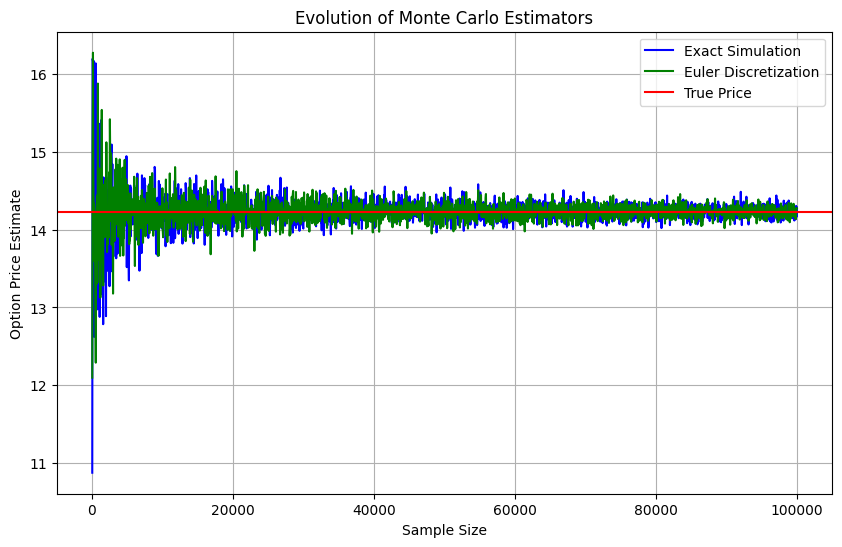

In [51]:
import matplotlib.pyplot as plt

# Calculate the true price for reference.
true_price = black_scholes_call_price(S_0, K, T, r, sigma)

# Exact simulation based on closed-form solution.
def exact_simulation(S_0, K, T, r, sigma, n):
    Z = np.random.normal(0, 1, n)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(S_T - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Biased simulation using Euler discretization.
def euler_simulation(S_0, K, T, r, sigma, m, n):
    dt = T / m
    S_T = S_0 * np.ones(n)
    for _ in range(m):
        Z = np.random.normal(0, 1, n)
        S_T *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    payoffs = np.maximum(S_T - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)


# Prepare lists to store results.
sample_sizes = range(50, n + 1, 50)
exact_estimates = []
euler_estimates = []

# Calculate estimators for different sample sizes.
for k in sample_sizes:
    exact_estimates.append(exact_simulation(S_0, K, T, r, sigma, k))
    euler_estimates.append(euler_simulation(S_0, K, T, r, sigma, m, k))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, exact_estimates, label='Exact Simulation', color='blue')
plt.plot(sample_sizes, euler_estimates, label='Euler Discretization', color='green')
plt.axhline(y=true_price, color='red', linestyle='-', label='True Price')
plt.xlabel('Sample Size')
plt.ylabel('Option Price Estimate')
plt.title('Evolution of Monte Carlo Estimators')
plt.legend()
plt.grid(True)
plt.show()

d. What are the two sources of error that result in the Monte Carlo estimators in parts (a) and (b) not being equal to the true price of the option? How can each of those errors be reduced?

##### MC Estimator Error Sources

The discrepancy between the Monte Carlo estimators and the true price of an option can primarily be attributed to two sources of error:

1. **Sampling Error**: This error arises due to the inherent *randomness/stochastic nature* in the Monte Carlo simulation process. Since we use a finite number of simulated paths (samples) to estimate the expected payoff, the calculated option price is subject to variability.

   - **How to Reduce**: The sampling error can be reduced by increasing the number of simulated paths, $n$. The **Law of Large Numbers** (LLN) indicates that as $n$ approaches infinity, the Monte Carlo estimator will converge to the true expected value. However, increasing $n$ also increases computational time.

2. **Discretization Error**: This error is specific to the Euler discretization method (part b) and occurs because we approximate the continuous GBM process with a *discrete set of steps*. The true path of the underlying asset over the time to maturity is continuous and may exhibit variations that are not captured by a coarse discretization.

   - **How to Reduce**: Discretization error can be mitigated by increasing the number of discretization steps, $m$. A higher $m$ provides a finer approximation of the continuous process, capturing more accurately the path of the underlying asset. However, similar to sampling error mitigation, increasing $m$ requires more computational resources.

e. In a single plot, display overlapping histograms for the simulated stock prices at time $T = 1$ in parts (a) and (b). How do the two simulated distributions differ? Is their difference consistent with the simulation bias observed in part (c)?

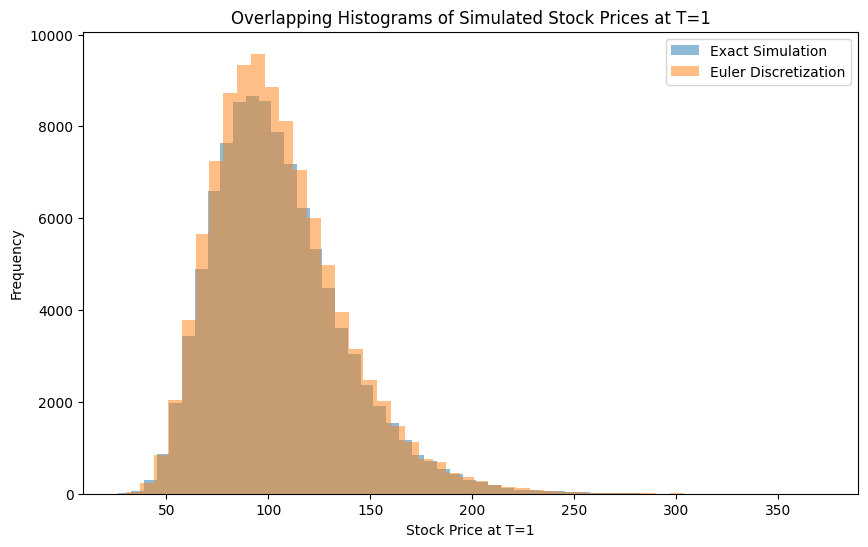

In [54]:
# Exact simulation stock prices at T = 1 using closed-form solution.
Z = np.random.normal(0, 1, n)
ST_exact = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Biased simulation stock prices at T=1 using Euler discretization.
dt = T / m
ST_euler = S0 * np.ones(n)
for _ in range(m):
    Z = np.random.normal(0, 1, n)
    ST_euler *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plotting overlapping histograms.
plt.figure(figsize=(10, 6))
plt.hist(ST_exact, bins=50, alpha=0.5, label='Exact Simulation')
plt.hist(ST_euler, bins=50, alpha=0.5, label='Euler Discretization')
plt.xlabel('Stock Price at T=1')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Simulated Stock Prices at T=1')
plt.legend()
plt.show()